<h1>QOSF Task 1</h1>
<p style="font-size:xx-large;">QuantumGirlsEG Team</p>

## Initialization

To ensure the demonstrations and exercises have the required Python modules and libraries, run the following cell before continuing.

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

## Table of Contents

The notebook is structured as follows:

1. Initialization
2. Table of Contents
3. Qiskit Soluation for Task1
    1. Decimal to Binary Function
    2. Construct Problem Oracle
    3. Diffuser Function
    4. The Full Algorithm
    5. The required output


## Decimal to Binary Function

This function (dectoBinFunc)is converting any decimal list to binary two- dimentional list. The length of the binary numbers will be mapped according to the maximum number of the list which is entered by the user.

In [126]:
# decimal to binary number conversion
# using bin() + list comprehension
def dectoBinFunc(decimalList):
    # initializing Variables 
    #decimalList =[1,5,7,10,127] # It can be an input from the user
    decimalList=[int(i) for i in decimalList]
    binaryList=[]     #Binary list for the decimal list
    binaryLengthMax=1 # Maximum binary number Length(the greatest number in the integer list)
    myBinaryLength=[] #Actual length for each binary Number

    #Converting to binary numbers
    for decimalIndex in range (len(decimalList)): # Looping on each decimal Number
        myBinaryLength.append(int(0))
        binaryNum=[]
        for index in bin(decimalList[decimalIndex])[2:]: # Decimal to Binary converting
            binaryNum.append(int(index))
            myBinaryLength[decimalIndex]+=1
        binaryList.append(binaryNum)
        if myBinaryLength[decimalIndex] > binaryLengthMax: #Storing the binary length of the maximum decimal number to determine the max number of qubits
            binaryLengthMax= (myBinaryLength[decimalIndex])


    #Adding zeros beside the left signficant bit if the binary length is less than binaryLengthMax
    #Left appending zeros to the binary numbers which has binary length less than binaryLengthMax
    for  index in range (len(binaryList)):
        if  binaryLengthMax > myBinaryLength[index]:
            ## Here insert leftzeros= binaryLengthMax - myBinaryLength[index]
            for i in range(binaryLengthMax - myBinaryLength[index]):
                binaryList[index].insert(i,0)
   
    return binaryList, binaryLengthMax
     


In [130]:
# Ask The user to insert the list of decimal number to convert to binary list
decList = input('Enter the decimal numbers (Space separating and You should enter 2^n numbers): ').split()
binaryList, binaryLengthMax= dectoBinFunc(decList)

print ("The converted binary list is : " +  str(binaryList))
#print(binaryLengthMax)

Enter the decimal numbers (Space separating and You should enter 2^n numbers): 1 2 5 7
The converted binary list is : [[0, 0, 1], [0, 1, 0], [1, 0, 1], [1, 1, 1]]


## Construct Problem Oracle
The provided oracle of the problems depends on the length of the binary numbers (The length of the maximum number. the number of input qubits) which is implemented in dectoBinFunc previously. The oracle idea depends on construct a quantum circuit which can XOR between each and every combination of the input qubits(var_qubits). 

<p style="font-size:large;"> The steps of the oracle are: </p>

1- Make Xoring for each bit and its neighbour.

2- Applying multi-controlled-toffoli(mct) gate.

3- reset clause-checking bits (Cs) to 0.



The following figure shows the oracle steps:

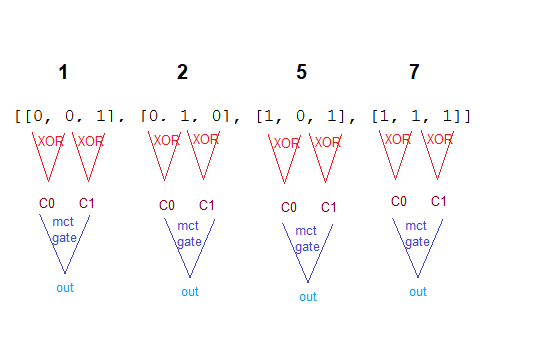

In [129]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

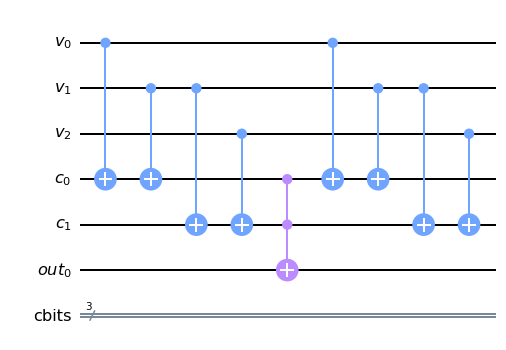

In [114]:
var_qubits = QuantumRegister(binaryLengthMax, name='v')# binaryLengthMax= m
if binaryLengthMax!=2:
    clause_qubits = QuantumRegister((binaryLengthMax-1), name='c') 
else:
    clause_qubits = QuantumRegister((binaryLengthMax), name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(binaryLengthMax, name='cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def QOSF_task1_oracle(qc, binaryList, clause_qubits):
## Clauses Computing (Make xoring for each bit with its neighbour)
    i = 0
    if binaryLengthMax!=2:
        for k in range (binaryLengthMax-1):
            if k == 1: # Make Xoring with the previous and next bit if k=1
                    XOR(qc, (k-1), k, clause_qubits[i])
                    XOR(qc, k, (k+1), clause_qubits[(i+1)])
                    j=i+1
            elif k != 1 and k != 0: # Make Xoring with the next bit for the other indices
                    j=j+ 1
                    XOR(qc, k, k+1, clause_qubits[(j)])
    else: # binaryLengthMax == 2
        for k in range(binaryLengthMax):
            if k==0:
                XOR(qc, k, (k+1), clause_qubits[k])
            else:
                XOR(qc, k-1, k, clause_qubits[k])

       
    
## Flip 'output' bit if all clauses are satisfied 
    qc.mct(clause_qubits, output_qubit)
    
    
## Uncompute clauses to reset clause-checking bits (Cs) to 0
    i = 0
    if binaryLengthMax!=2:
        for k in range (binaryLengthMax-1):
            if k == 1: # Make Xoring with the previous and next bit if k=1
                    XOR(qc, (k-1), k, clause_qubits[i])
                    XOR(qc, k, (k+1), clause_qubits[(i+1)])
                    j=i+1
            elif k != 1 and k != 0: # Make Xoring with the next bit for the other indices
                    j=j+ 1
                    XOR(qc, k, k+1, clause_qubits[(j)])
    else: # binaryLengthMax == 2
        for k in range(binaryLengthMax):
            if k==0:
                XOR(qc, k, (k+1), clause_qubits[k])
            else:
                XOR(qc, k-1, k, clause_qubits[k])



                    
                    
                    

QOSF_task1_oracle(qc, binaryList, clause_qubits)
qc.draw(output='mpl',fold=-1)

# Diffuser Function

In [115]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

# The Full Algorithm

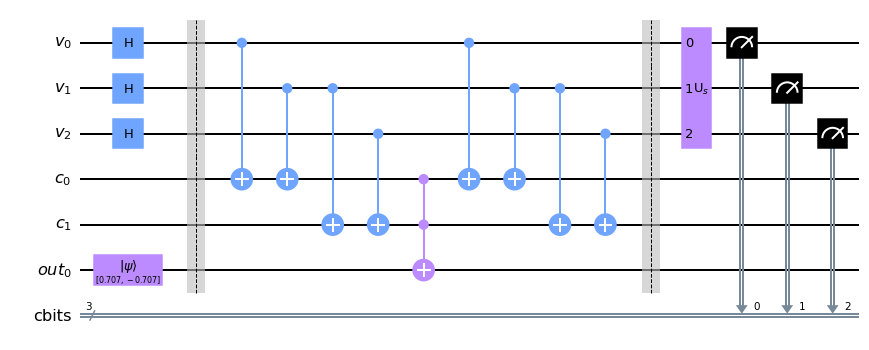

In [131]:
var_qubits = QuantumRegister(binaryLengthMax, name='v')# binaryLengthMax= m
if binaryLengthMax!=2:
    clause_qubits = QuantumRegister((binaryLengthMax-1), name='c') 
else:
    clause_qubits = QuantumRegister((binaryLengthMax), name='c')
output_qubits = QuantumRegister(1, name='out')
cbits = ClassicalRegister(binaryLengthMax, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

## Initialize 'outputs' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubits)
    
    
## Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation



## First Iteration
# Apply our oracle
QOSF_task1_oracle(qc, binaryList, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(binaryLengthMax), list(range(binaryLengthMax)))



# Measure the variable qubits
qc.measure(var_qubits, cbits)
#qc.measure_all()
qc.draw(output='mpl',fold=-1)

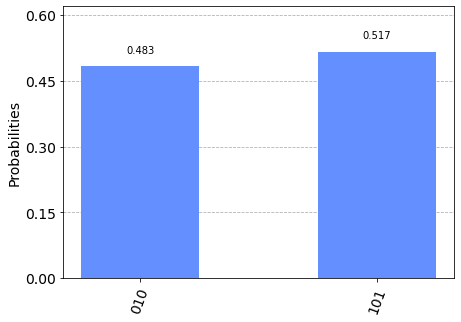

In [122]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())

## The required output   (still in progress)

The required output is the superposition of states where each state is a binary representation of the indices of desired integers. 

This can be cheived as follows:

1- Check the keys of the simulator counts with the input list.

2- Get the indecies in the list item when the simulator counts equals the item.

3- Get the number of the qubits (n) depends on the number of the list items.

4- Apply an oracle and diffuser for the circuit


In [142]:
resultKeys=list(result.get_counts().keys())
for binaryNum in binaryList:
    for key in resultKeys:
        
n = int(math.log(len(binaryList), 2))
print(resultKeys, n)

['101', '010'] 2


In [2]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Qiskit Software,Version
qiskit-terra,0.18.1
qiskit-aer,0.8.2
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.16.0
qiskit-aqua,0.9.4
qiskit,0.29.0
qiskit-nature,0.1.5
qiskit-finance,0.2.0
qiskit-optimization,0.2.1
qiskit-machine-learning,0.2.0
